In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [0]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


# converting the data type and scaling between 0 and 1
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

11493376/11490434 [==============================] - 0s 0us/step


Lets have a look at the dimensions of the cifar images and check out the first image in the dataset.

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)
(28, 28)


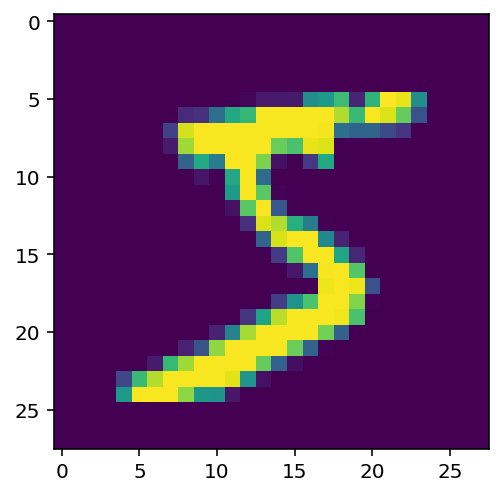

In [0]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])
print(image_size)

plt.imshow(x_train[0])

From this we can see that we have images that are 32 * 32 * 3. This means we have a 32 * 32 image with 3 different colour channels (RGB).
If we convert this to a vector we will have a vector of length 32 * 32 * 3 = 3072, which is significanlty larger than what we had to deal with for MNIST. 

Let's reshape (flatten) these arrays. The images will be converted to vectors. However, unlike last time, we aren't going to overwrite the x_train and x_test objects, we will keep them around for later.


In [0]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1]


x_train_vector = x_train.reshape(x_train.shape[0], image_vector_size)

x_test_vector = x_test.reshape(x_test.shape[0], image_vector_size)

print(x_train_vector.shape)

(60000, 784)


Before moving onto building the network we need to convert the labels into one-hot-encoded target labels. Like last time we are using the to_categorical function to do this.


In [0]:
print("First 5 training labels: ", y_train[:5]) 

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(60000, 10)


Lets build a simple fully connected model similar to last week, but with two hidden layers this time.

In [0]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=800, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=800, activation='sigmoid'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 800)               628000    
_________________________________________________________________
dense_11 (Dense)             (None, 800)               640800    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                8010      
Total params: 1,276,810
Trainable params: 1,276,810
Non-trainable params: 0
_________________________________________________________________


With nearly 3.5 million parameters to learn, our model is much bigger than last time.
Let's compile the model with an ADAM optimizer.

In [0]:
model.compile(optimizer="SGD", loss='categorical_crossentropy', metrics=['accuracy'])

Learning from the last lab, we will train for 50 epochs the first time around.

In [0]:
history = model.fit(x_train_vector, y_train, batch_size=32, epochs=10, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test_vector, y_test, verbose=False)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 5s 95us/step - loss: 2.1197 - accuracy: 0.3294 - val_loss: 1.8281 - val_accuracy: 0.4058
Epoch 2/10
54000/54000 [==============================] - 5s 95us/step - loss: 1.3989 - accuracy: 0.6779 - val_loss: 0.9650 - val_accuracy: 0.7960
Epoch 3/10
54000/54000 [==============================] - 5s 94us/step - loss: 0.8323 - accuracy: 0.7944 - val_loss: 0.6301 - val_accuracy: 0.8487
Epoch 4/10
54000/54000 [==============================] - 5s 94us/step - loss: 0.6179 - accuracy: 0.8385 - val_loss: 0.4828 - val_accuracy: 0.8820
Epoch 5/10
54000/54000 [==============================] - 5s 94us/step - loss: 0.5185 - accuracy: 0.8601 - val_loss: 0.4229 - val_accuracy: 0.8850
Epoch 6/10
54000/54000 [==============================] - 5s 95us/step - loss: 0.4632 - accuracy: 0.8719 - val_loss: 0.3762 - val_accuracy: 0.8993
Epoch 7/10
54000/54000 [==============================] - 5s 95us/ste

That seems to be learning well, lets have a look at the loss /accuracy curves.

Test loss: 0.352
Test accuracy: 0.896


<Figure size 576x432 with 0 Axes>

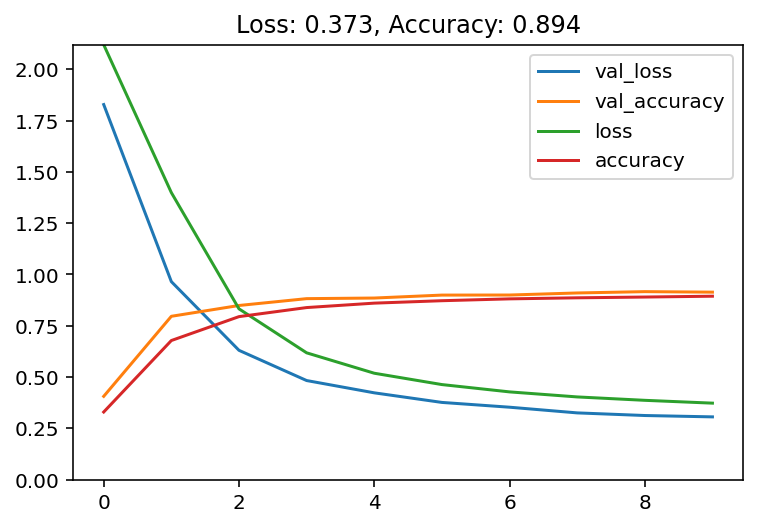

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=800, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dropout(0.8))
  model.add(Dense(units=800, activation='sigmoid'))
  model.add(Dropout(0.5))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 800)               628000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 800)               640800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                8010      
Total params: 1,276,810
Trainable params: 1,276,810
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="SGD", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train_vector, y_train, batch_size=32, epochs=10, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test_vector, y_test, verbose=False)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 6s 109us/step - loss: 2.4156 - accuracy: 0.1261 - val_loss: 2.1369 - val_accuracy: 0.4418
Epoch 2/10
54000/54000 [==============================] - 6s 107us/step - loss: 2.1866 - accuracy: 0.2044 - val_loss: 1.8813 - val_accuracy: 0.5090
Epoch 3/10
54000/54000 [==============================] - 6s 106us/step - loss: 1.9131 - accuracy: 0.3202 - val_loss: 1.4294 - val_accuracy: 0.6200
Epoch 4/10
54000/54000 [==============================] - 6s 107us/step - loss: 1.5860 - accuracy: 0.4323 - val_loss: 1.0651 - val_accuracy: 0.7525
Epoch 5/10
54000/54000 [==============================] - 6s 108us/step - loss: 1.3442 - accuracy: 0.5135 - val_loss: 0.8672 - val_accuracy: 0.7837
Epoch 6/10
54000/54000 [==============================] - 6s 107us/step - loss: 1.1867 - accuracy: 0.5739 - val_loss: 0.7550 - val_accuracy: 0.7833
Epoch 7/10
54000/54000 [==============================] - 6s 10

Test loss: 0.57
Test accuracy: 0.83


<Figure size 576x432 with 0 Axes>

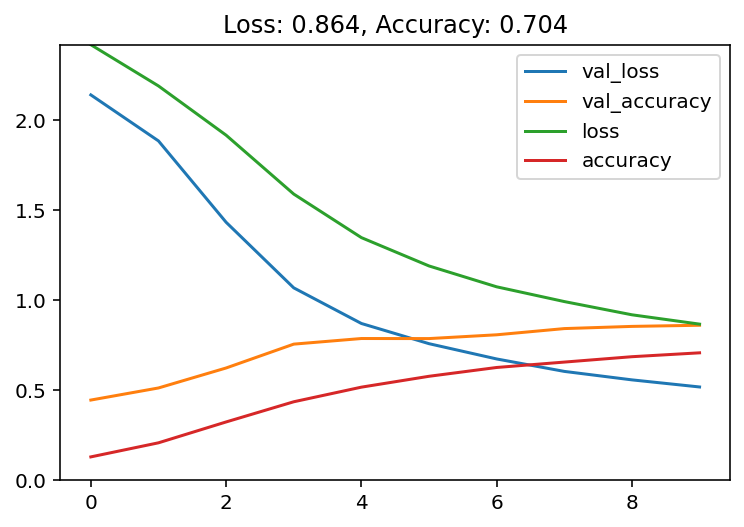

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=800, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 800)               628000    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="SGD", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train_vector, y_train, batch_size=32, epochs=50, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test_vector, y_test, verbose=False)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 191us/step - loss: 1.3320 - accuracy: 0.7007 - val_loss: 0.7255 - val_accuracy: 0.8623
Epoch 2/50
54000/54000 [==============================] - 11s 202us/step - loss: 0.6461 - accuracy: 0.8474 - val_loss: 0.4727 - val_accuracy: 0.8940
Epoch 3/50
54000/54000 [==============================] - 10s 179us/step - loss: 0.5009 - accuracy: 0.8714 - val_loss: 0.3885 - val_accuracy: 0.9055
Epoch 4/50
54000/54000 [==============================] - 10s 180us/step - loss: 0.4398 - accuracy: 0.8814 - val_loss: 0.3468 - val_accuracy: 0.9095
Epoch 5/50
54000/54000 [==============================] - 10s 184us/step - loss: 0.4055 - accuracy: 0.8881 - val_loss: 0.3273 - val_accuracy: 0.9093
Epoch 6/50
54000/54000 [==============================] - 10s 181us/step - loss: 0.3837 - accuracy: 0.8917 - val_loss: 0.3082 - val_accuracy: 0.9157
Epoch 7/50
54000/54000 [==============================] -

Test loss: 0.252
Test accuracy: 0.928


<Figure size 576x432 with 0 Axes>

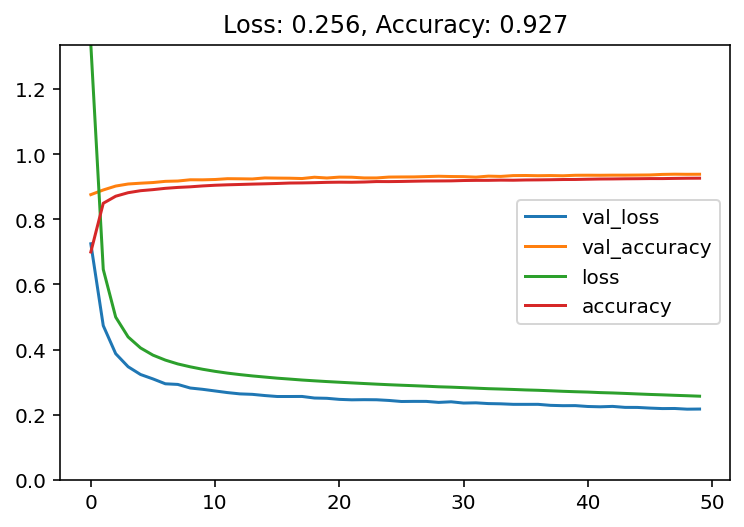

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [0]:
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=800, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dropout(0.2))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
model = build_basic_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 800)               628000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="SGD", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(x_train_vector, y_train, batch_size=32, epochs=50, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(x_test_vector, y_test, verbose=False)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 12s 231us/step - loss: 1.3971 - accuracy: 0.6046 - val_loss: 0.7362 - val_accuracy: 0.8638
Epoch 2/50
54000/54000 [==============================] - 12s 218us/step - loss: 0.7207 - accuracy: 0.8024 - val_loss: 0.4827 - val_accuracy: 0.8863
Epoch 3/50
54000/54000 [==============================] - 12s 214us/step - loss: 0.5650 - accuracy: 0.8385 - val_loss: 0.3915 - val_accuracy: 0.9033
Epoch 4/50
54000/54000 [==============================] - 11s 212us/step - loss: 0.5001 - accuracy: 0.8539 - val_loss: 0.3528 - val_accuracy: 0.9070
Epoch 5/50
54000/54000 [==============================] - 12s 215us/step - loss: 0.4608 - accuracy: 0.8661 - val_loss: 0.3275 - val_accuracy: 0.9128
Epoch 6/50
54000/54000 [==============================] - 12s 214us/step - loss: 0.4370 - accuracy: 0.8705 - val_loss: 0.3115 - val_accuracy: 0.9132
Epoch 7/50
54000/54000 [==============================] -

Test loss: 0.244
Test accuracy: 0.93


<Figure size 576x432 with 0 Axes>

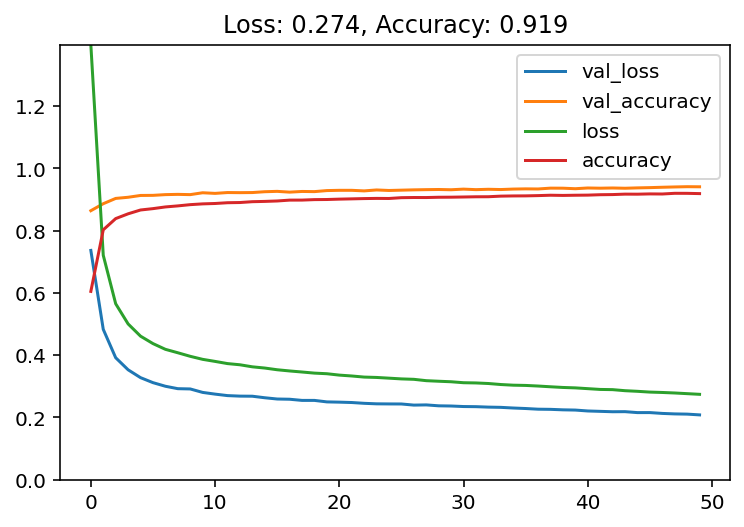

In [0]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')